# Testing a simple workflow

- Import dataset, do some clean up, fix scitypes
- Unpack predictors and response variable
- Load a ridge regressor model
- Create a pipeline with the following steps:
    - Standardize all continuous predictors
    - One hot encode all multiclass predictors
    - Transform target using log
    - Inverse target using exp

In [1]:
using CairoMakie
using CSV
using DataFrames
using MLJ
using MLJBase

In [2]:
# Import training dataset
lichen_training = CSV.read("C:/Users/julio/Downloads/lichen_training.csv", DataFrame; missingstring="NA") |>
dropmissing |>
x -> DataFrames.select(x, "Total.lichen", "basal_area", "PL", "mean_Long", "mean_Lat", "SX", "SNR") |>
x -> rename(x, ["biomass", "basalarea", "pl", "lon", "lat", "sx", "snr"]) |>
x -> coerce(x, Count=>Continuous, Textual=>Multiclass)

,biomass,basalarea,pl,lon,lat,sx,snr
,Float64,Float64,Float64,Float64,Float64,Float64,Cat…
1,3.3,5.52,0.0,-124.205,55.2704,0.0,B
2,1.97,10.44,0.0,-124.202,55.2649,60.0,C
3,1158.52,16.42,100.0,-124.633,55.4289,0.0,C
4,3474.61,7.77,100.0,-124.622,55.4232,0.0,C
5,1.72,22.54,0.0,-124.625,55.4193,60.0,C
6,3462.56,15.24,100.0,-124.64,55.4299,0.0,C
7,1.93,30.54,0.0,-124.33,55.3043,0.0,C
8,3.53,16.0,0.0,-124.323,55.3038,0.0,C
9,1.56,36.82,0.0,-124.323,55.3021,80.0,C


In [3]:
# Unpack predictors and response variable
y, X = unpack(lichen_training, ==(:biomass), _->true);

In [4]:
# Find best lambda for the ridge regressor model
model = @load RidgeRegressor pkg=MLJLinearModels verbosity=0
pipe = @pipeline Standardizer OneHotEncoder model target=v->log.(v) inverse=v->exp.(v)
r = range(pipe, :(ridge_regressor.lambda), lower=0.5, upper=10)
tunned = TunedModel(model=pipe, ranges=r, tuning=Grid(), resampling=CV(nfolds=3, rng=4141), measure=rms)
mach = machine(tunned, X, y)
fit!(mach, verbosity=0)

best = fitted_params(mach).best_model
@show best.ridge_regressor.lambda;

best.ridge_regressor.lambda = 2.611111111111111


┌ Info: Treating pipeline as a `Deterministic` predictor.
│ To override, specify `prediction_type=...` (options: :deterministic, :probabilistic, :interval). 
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\composition\models\pipelines.jl:372


In [5]:
tunned

DeterministicTunedModel(
    model = Pipeline281(
            standardizer = Standardizer,
            one_hot_encoder = OneHotEncoder,
            ridge_regressor = RidgeRegressor,
            target = WrappedFunction,
            inverse = WrappedFunction),
    tuning = Grid(
            goal = nothing,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 3,
            shuffle = true,
            rng = Random.MersenneTwister(4141)),
    measure = RootMeanSquaredError(),
    weights = nothing,
    operation = nothing,
    range = NumericRange(0.5 ≤ ridge_regressor.lambda ≤ 10.0; origin=5.25, unit=4.75),
    selection_heuristic = MLJTuning.NaiveSelection(nothing),
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPU1{Nothing}(nothing),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true,
    cache = true)

In [12]:
mach

Machine{DeterministicTunedModel{Grid,…},…} trained 1 time; caches data
  args: 
    1:	Source @778 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}}}`
    2:	Source @753 ⏎ `AbstractVector{Continuous}`


In [7]:
# Get the fitted parameters
fp = fitted_params(mach);

In [8]:
# Regressor coefficients
fp.best_fitted_params.ridge_regressor.coefs

8-element Vector{Pair{Symbol, Float64}}:
 :basalarea => -0.695764478277363
        :pl => 0.92362330858313
       :lon => -0.8507694266049083
       :lat => 0.10978843082177658
        :sx => 0.13492580627217904
    :snr__A => 0.704841112045112
    :snr__B => 1.6708114924849464
    :snr__C => 1.0585751852386145

In [17]:
# Evaluate the model
pipe.ridge_regressor.lambda = best.ridge_regressor.lambda
# m = machine(pipe, X, y)
evaluate!(
    mach,
    resampling=CV(nfolds=10),
    measure=[mae, rms],
    verbosity=0
)

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────┬─────────────┬───────────┬────────────────────────────
│ measure                │ measurement │ operation │ per_fold                  ⋯
├────────────────────────┼─────────────┼───────────┼────────────────────────────
│ MeanAbsoluteError()    │ 641.0       │ predict   │ [988.0, 580.0, 836.0, 117 ⋯
│ RootMeanSquaredError() │ 1070.0      │ predict   │ [1690.0, 856.0, 1220.0, 1 ⋯
└────────────────────────┴─────────────┴───────────┴────────────────────────────
                                                                1 column omitted


In [20]:
# Fit and predict
fit!(mach, verbosity=0)
ŷ = predict(mach)
@show rms(ŷ, y)
@show mae(ŷ, y);

rms(ŷ, y) = 1041.6090921873476
mae(ŷ, y) = 599.5146562744504


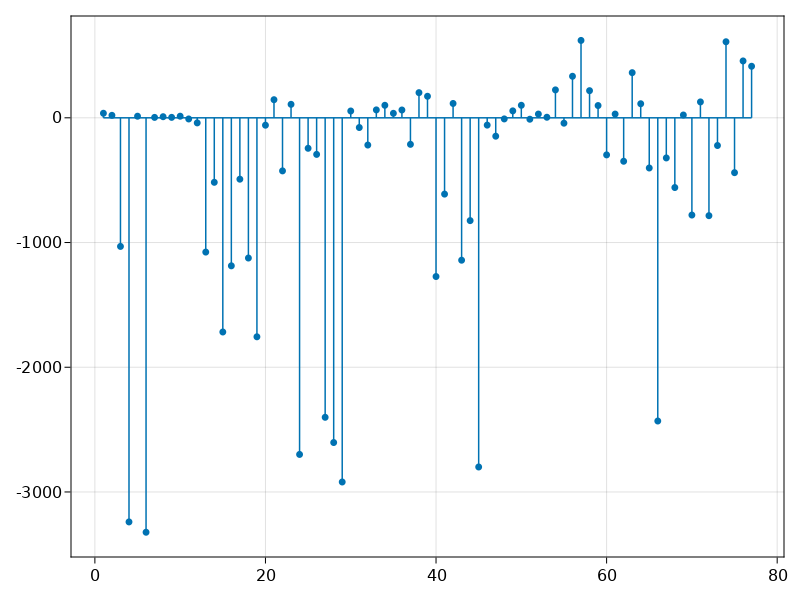

In [21]:
# Residuals
stem(ŷ - y)

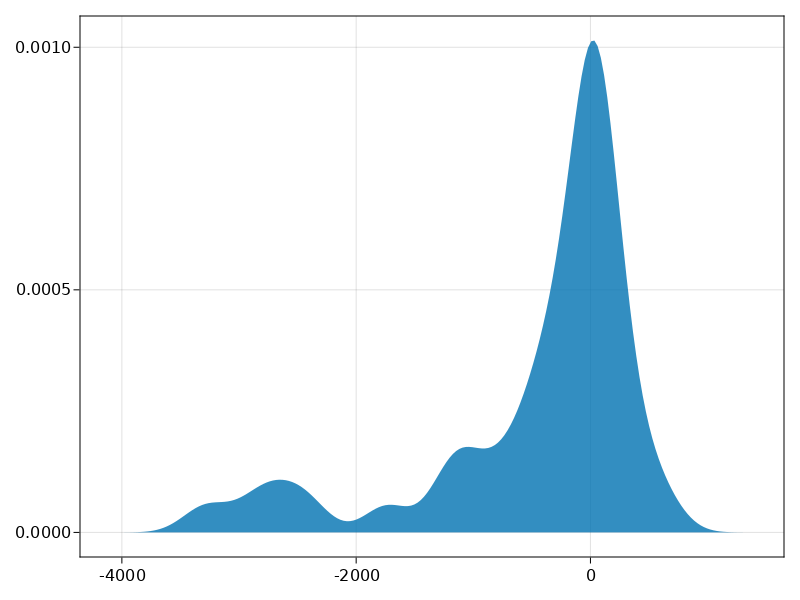

In [22]:
# Residuals density
density(ŷ - y)